In [1]:
import dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve,auc, RocCurveDisplay

In [2]:
dataset_path = 'dataset.parquet'

In [3]:
ds = dataset.VorAusDataset(dataset_path)

In [4]:
X_train, y_train, X_test, y_test = ds.get_prepared_dataset_tts(test_size = 0.15, random_state=42)

## Model evaluation

In [5]:
class Model:
    def __init__(self, model,name=None, scaled=False):
        self.model = model
        self.name = name
    def fit(self):
        self.model.fit(X_train, y_train)
    def __get_predictions(self):
        return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]

    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series

    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

* $Recall = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$
    * In words, recall answers the question: "Out of all the actual positive instances, how many did the model correctly identify?" It is particularly important in situations where the cost of missing positive instances (false negatives) is high, and you want to minimize the chances of false negatives.


* $Precision = \frac{\text{True Positive}}{\text{True Positive} + \text{False Positive}}$ 
    * In words, precision answers the question: "Out of all the instances predicted as positive by the model, how many were actually positive?" It is particularly important in situations where the cost of false positives (instances predicted as positive but are actually negative) is high, and you want to minimize the chances of making false positive predictions.
* $Accuracy = \frac{\text{True Positive} + \text{True Negative}}{\text{True Positive} + \text{True Negative} + \text{False Positive} + \text{False Negative}}$
* $F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} \times \text{Recall}}$
    * In words, the F1 score provides a balance between precision and recall. It ranges from 0 to 1, where 1 indicates perfect precision and recall, and 0 indicates poor performance

In [6]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
            'Precision',
            'Recall',
            'F1-Score',
            'ROC AUC',
            'Confusion Matrix',
            'PR AUC'])

## Logistic Regression

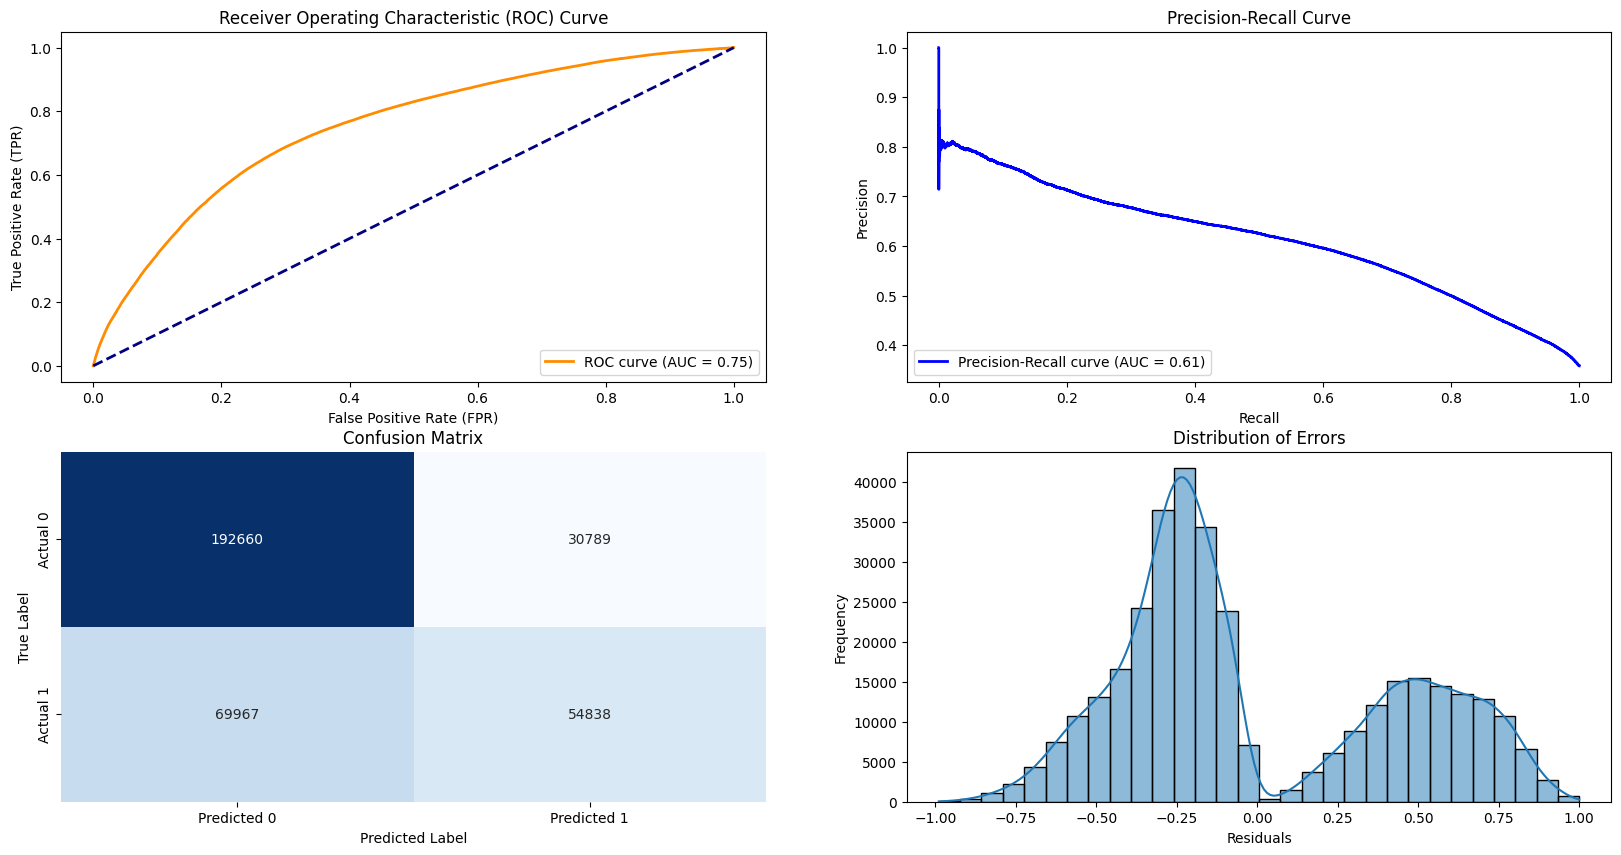

In [7]:
model = Model(LogisticRegression(solver='newton-cholesky'),'Logistic Regression')
model.fit()
model.visualize_metrics()

In [8]:
metrics_lr = model.get_metrics()
models_df = pd.concat([models_df, metrics_lr.to_frame().T])
print(metrics_lr)

Accuracy                                     0.710682
Precision                                    0.640429
Recall                                       0.439389
F1-Score                                     0.521194
ROC AUC                                       0.74864
Confusion Matrix    [[192660, 30789], [69967, 54838]]
PR AUC                                       0.610888
Name                              Logistic Regression
dtype: object


In [9]:
del metrics_lr
del model

# Gaussian Naive Bayes

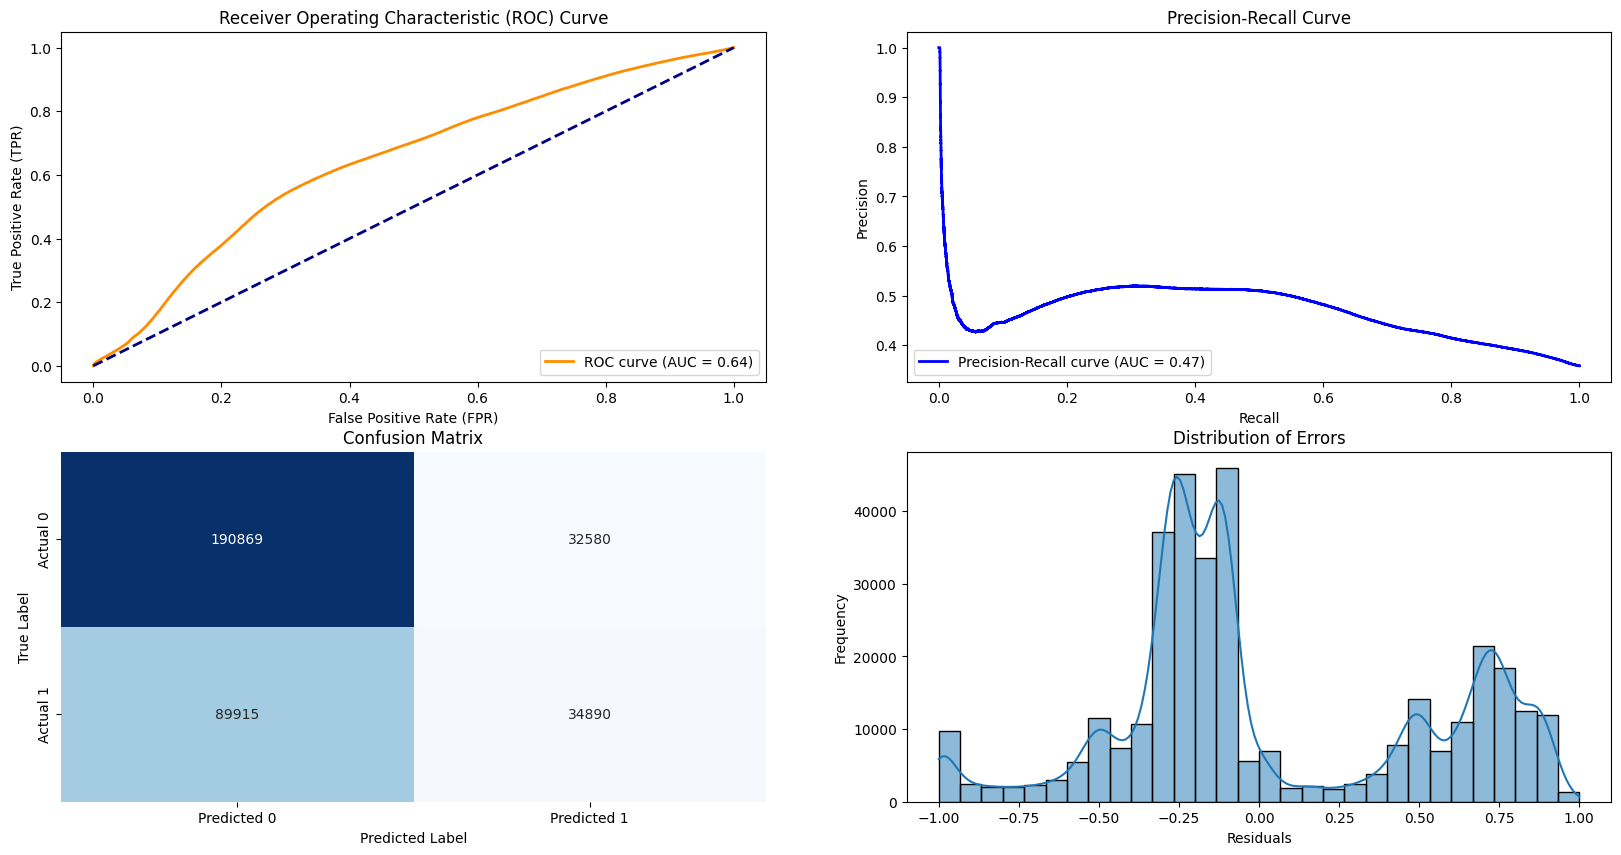

In [10]:
model = Model(GaussianNB(), 'Gaussian Naive Bayes')
model.fit()
model.visualize_metrics()

In [11]:
metrics_LB = model.get_metrics()
models_df = pd.concat([models_df, metrics_LB.to_frame().T])
print(metrics_LB)

Accuracy                                      0.64826
Precision                                    0.517119
Recall                                       0.279556
F1-Score                                     0.362918
ROC AUC                                      0.643212
Confusion Matrix    [[190869, 32580], [89915, 34890]]
PR AUC                                       0.466222
Name                             Gaussian Naive Bayes
dtype: object


In [12]:
del model
del metrics_LB

## Decision Tree

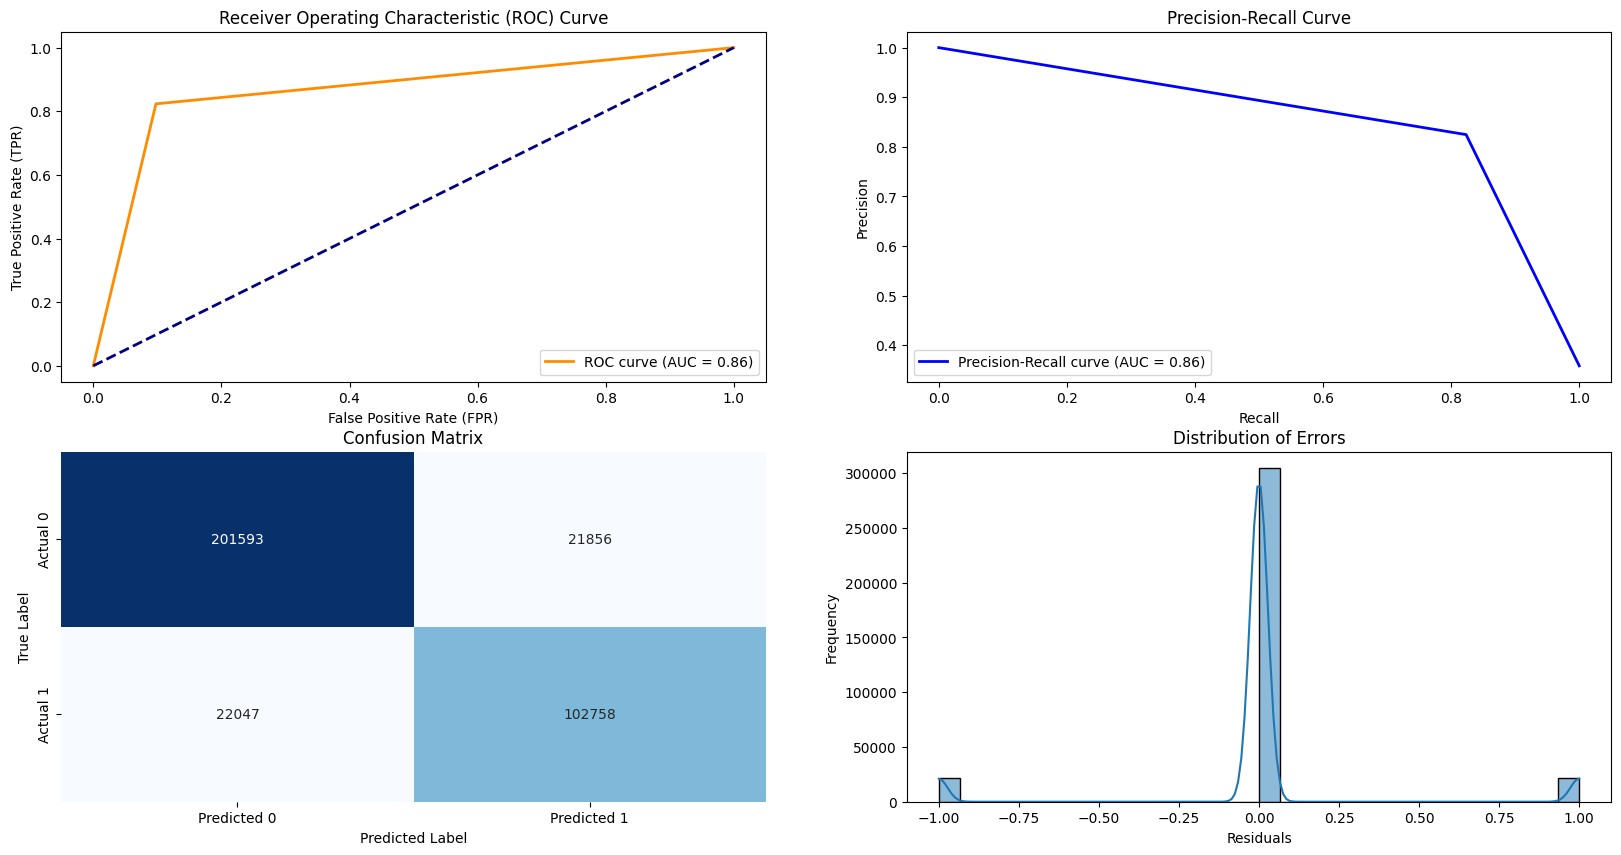

In [13]:
model = Model(DecisionTreeClassifier(), 'Decision Tree Classifier')
model.fit()
model.visualize_metrics()

In [14]:
metrics_DT = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT.to_frame().T])
print(metrics_DT)

Accuracy                                      0.873934
Precision                                      0.82461
Recall                                        0.823348
F1-Score                                      0.823979
ROC AUC                                       0.862768
Confusion Matrix    [[201593, 21856], [22047, 102758]]
PR AUC                                        0.742249
Name                          Decision Tree Classifier
dtype: object


In [15]:
del model
del metrics_DT

## Random Forest

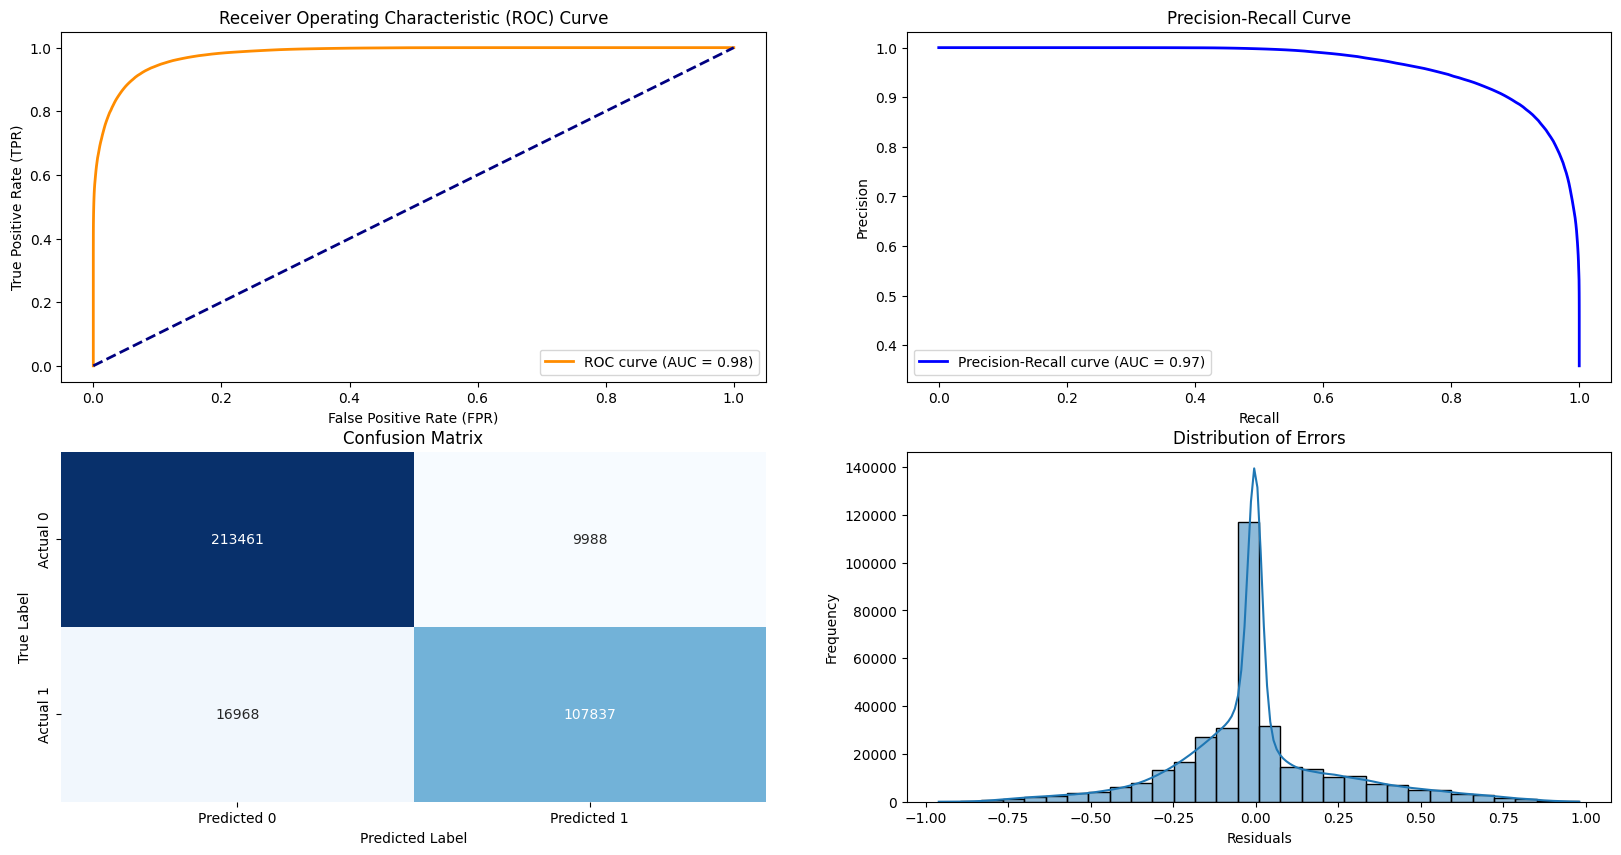

In [16]:
model = Model(RandomForestClassifier())
model.fit()
model.visualize_metrics()  

In [17]:
metrics_RandomForest = model.get_metrics()
models_df = pd.concat([models_df, metrics_RandomForest.to_frame().T])
print(metrics_RandomForest)

Accuracy                                     0.922597
Precision                                     0.91523
Recall                                       0.864044
F1-Score                                     0.888901
ROC AUC                                      0.979425
Confusion Matrix    [[213461, 9988], [16968, 107837]]
PR AUC                                       0.965173
Name                           RandomForestClassifier
dtype: object


In [18]:
del model

# Gradient Boosting

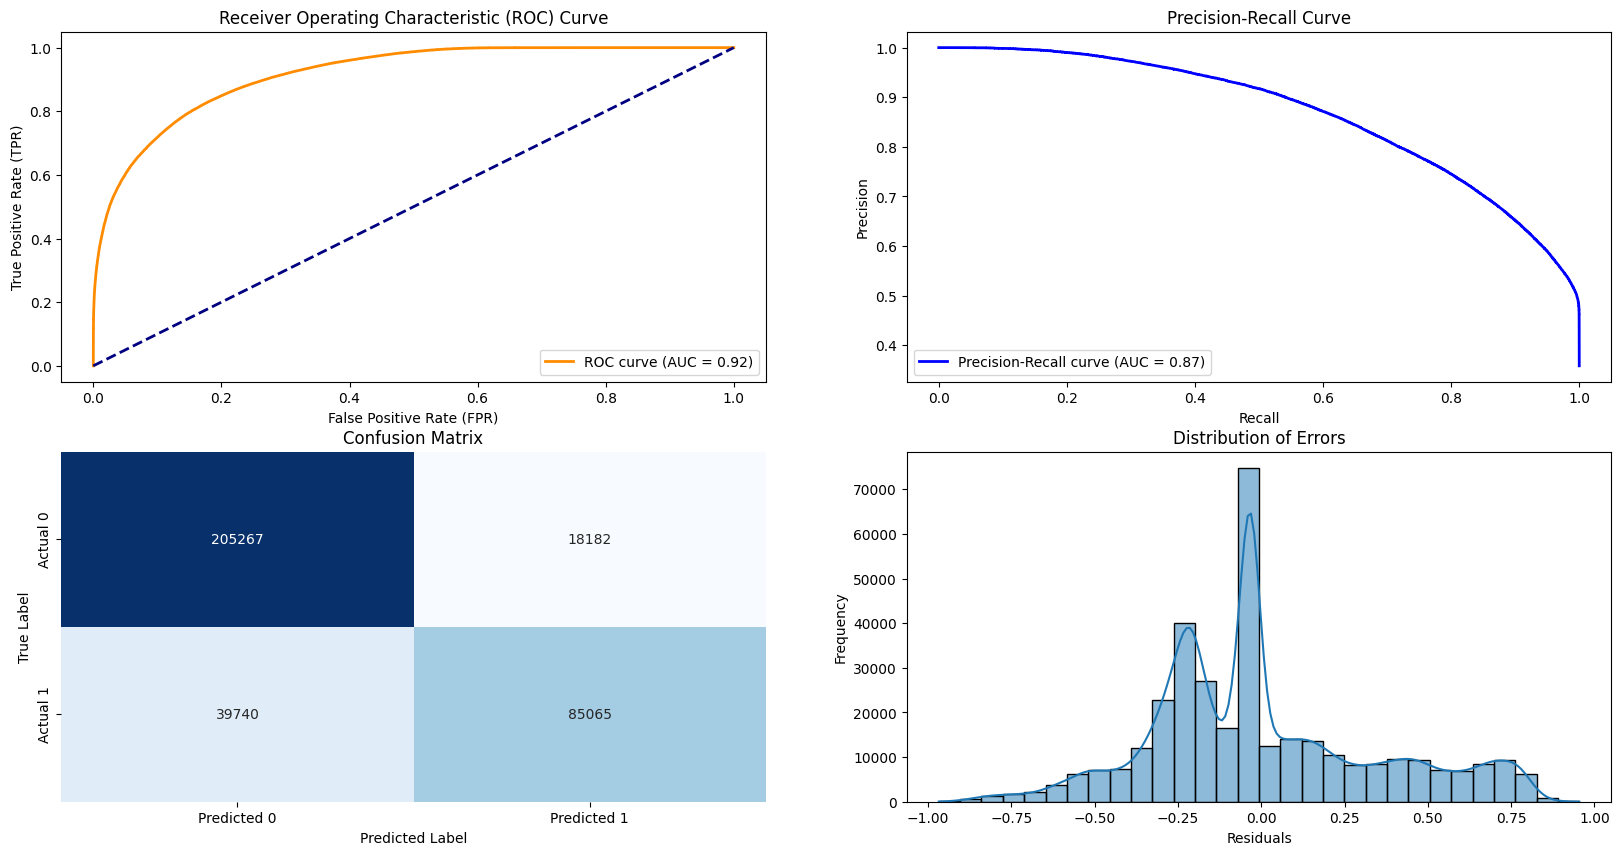

In [19]:
model = Model(GradientBoostingClassifier(n_estimators=50, learning_rate=0.2,max_depth=5,min_samples_leaf=50,
                                 min_samples_split=40,max_features='sqrt', random_state=42), name='Gradient Boosting Classifier')
model.fit()
model.visualize_metrics()

In [20]:
metrics_GBC = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC.to_frame().T])
print(metrics_GBC)

Accuracy                                     0.833679
Precision                                    0.823898
Recall                                       0.681583
F1-Score                                     0.746014
ROC AUC                                      0.915578
Confusion Matrix    [[205267, 18182], [39740, 85065]]
PR AUC                                       0.867363
Name                     Gradient Boosting Classifier
dtype: object


In [21]:
del model
del metrics_GBC

## Xg Boost

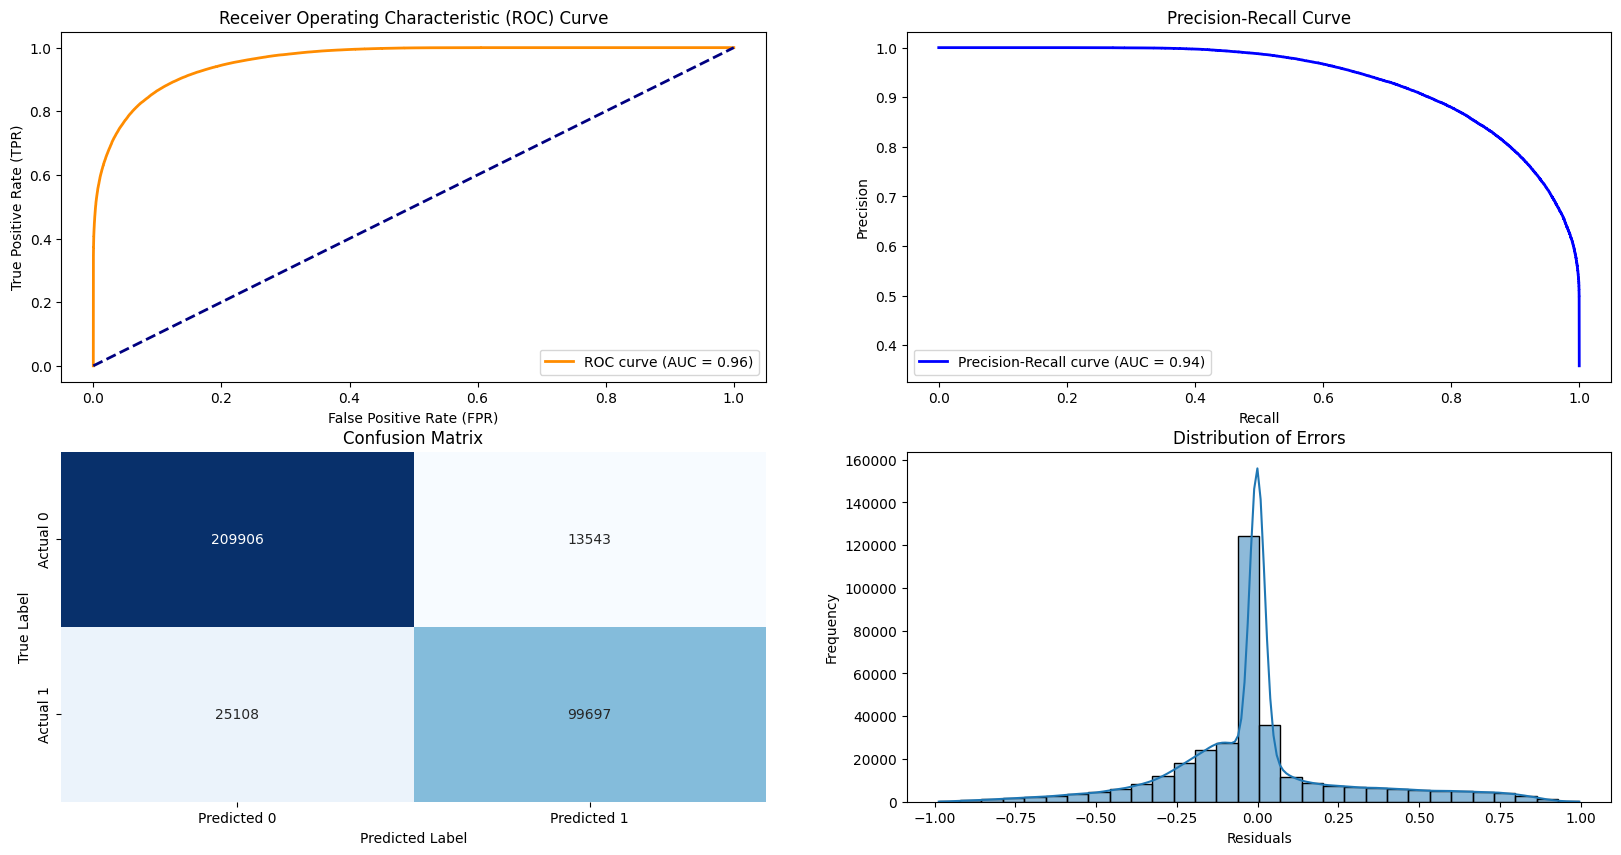

In [22]:
model = Model(XGBClassifier(), 'XGB classifier')
model.fit()
model.visualize_metrics()

In [23]:
metrics_XGBC = model.get_metrics()
models_df = pd.concat([models_df, metrics_XGBC.to_frame().T])
print(metrics_XGBC)

Accuracy                                     0.889015
Precision                                    0.880404
Recall                                       0.798822
F1-Score                                     0.837632
ROC AUC                                      0.960141
Confusion Matrix    [[209906, 13543], [25108, 99697]]
PR AUC                                       0.936866
Name                                   XGB classifier
dtype: object


# Conclusion

In [24]:
models_df

,Name,Accuracy,Precision,Recall,F1-Score,ROC AUC,Confusion Matrix,PR AUC
0,Logistic Regression,0.710682,0.640429,0.439389,0.521194,0.74864,"[[192660, 30789], [69967, 54838]]",0.610888
0,Gaussian Naive Bayes,0.64826,0.517119,0.279556,0.362918,0.643212,"[[190869, 32580], [89915, 34890]]",0.466222
0,Decision Tree Classifier,0.873934,0.82461,0.823348,0.823979,0.862768,"[[201593, 21856], [22047, 102758]]",0.742249
0,RandomForestClassifier,0.922597,0.91523,0.864044,0.888901,0.979425,"[[213461, 9988], [16968, 107837]]",0.965173
0,Gradient Boosting Classifier,0.833679,0.823898,0.681583,0.746014,0.915578,"[[205267, 18182], [39740, 85065]]",0.867363
0,XGB classifier,0.889015,0.880404,0.798822,0.837632,0.960141,"[[209906, 13543], [25108, 99697]]",0.936866


In [25]:
models_df.index = models_df.Name
models_df = models_df.drop('Name',axis=1)

<Axes: xlabel='Name'>

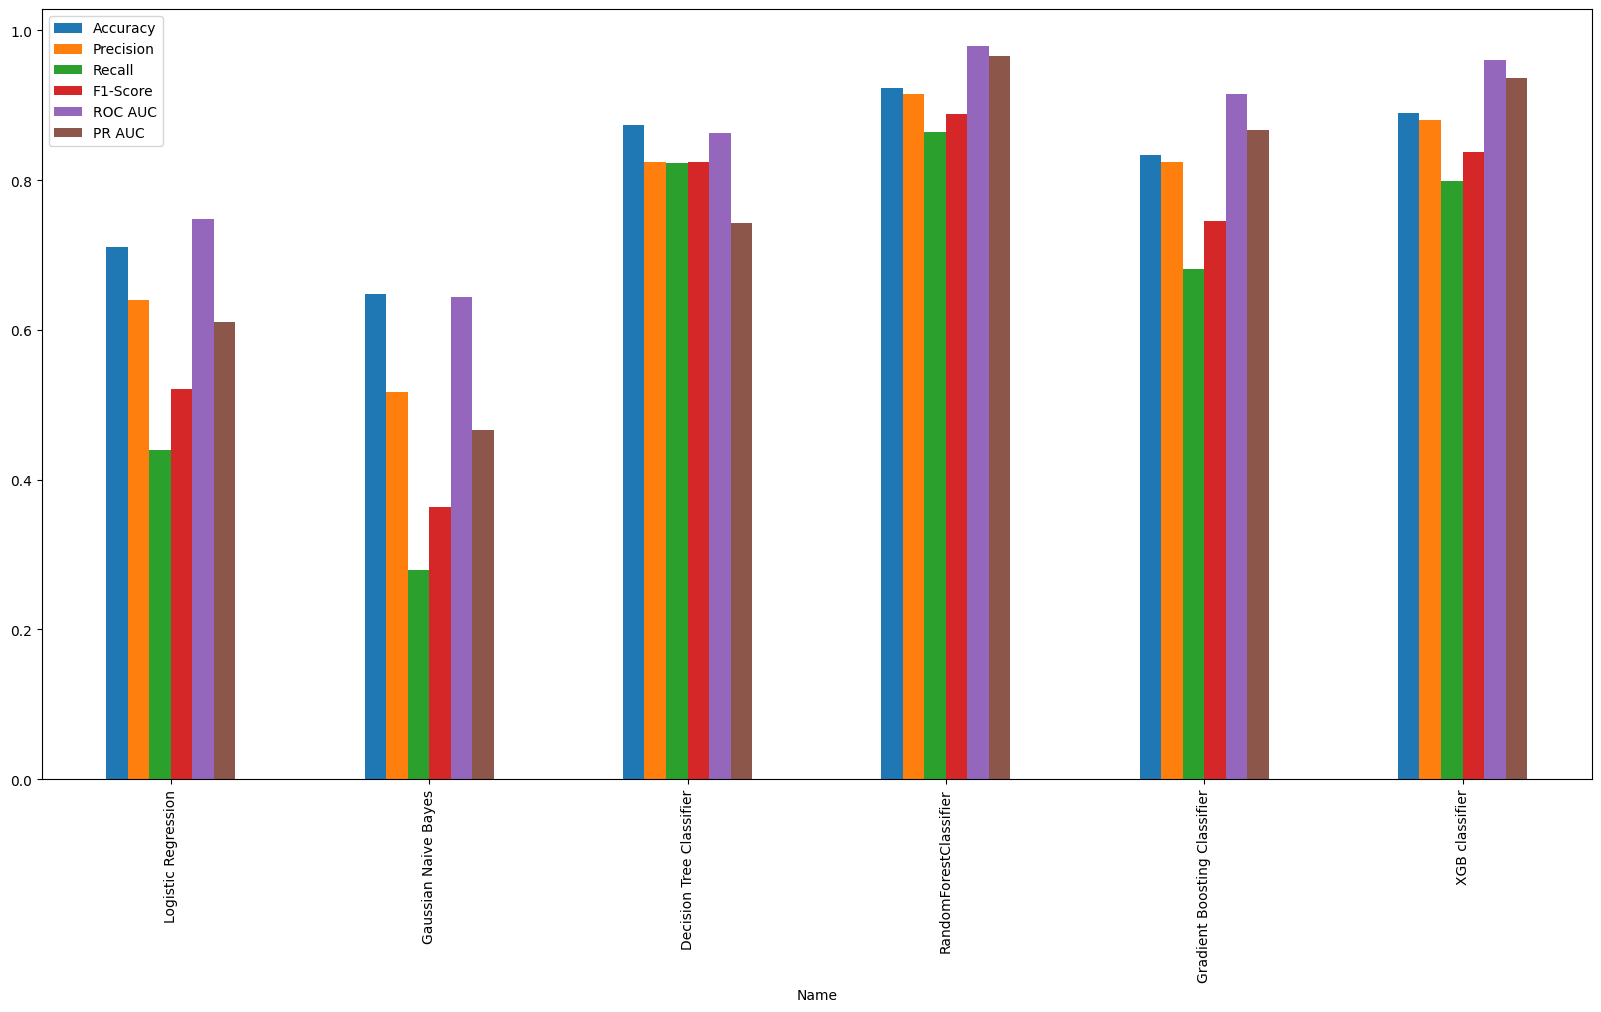

In [26]:
df = models_df[[x for x in models_df.columns if x != 'Confusion Matrix']]
df.plot.bar(figsize=(20,10))

In [27]:
for col in models_df.columns:
    if col != 'Confusion Matrix':
        print(models_df.sort_values(by=col, ascending=False)[col].head(1))

Name
RandomForestClassifier    0.922597
Name: Accuracy, dtype: object
Name
RandomForestClassifier    0.91523
Name: Precision, dtype: object
Name
RandomForestClassifier    0.864044
Name: Recall, dtype: object
Name
RandomForestClassifier    0.888901
Name: F1-Score, dtype: object
Name
RandomForestClassifier    0.979425
Name: ROC AUC, dtype: object
Name
RandomForestClassifier    0.965173
Name: PR AUC, dtype: object
